# Compare proseco acquisition probabilities to flight data

**This notebook compares the integrated acquisition success probability values
`p_acq_proseco` generated by proseco star selection to 7 months of flight acquisition
statistics (2024-10-14 to 2025-05-14).**

This represents data since the promotion of the
current flight acquisition probability model `grid-local-quadratic-2024-09`, thereby
ensuring consistent comparisons.

The integrated proseco `p_acq_proseco` starts from the pure model probability
`p_acq_model`, which is a function of `mag`, `t_ccd`, `halfwidth`. It then includes
factors like nearby spoiler stars, hot pixels, and the search box being partially off
the CCD. Therefore `p_acq_proseco < p_acq_model`.

The previous analysis (``compare-acq-model-to-flight-data.ipynb``) used `p_acq_model`
and therefore under-predicted the failure rate (`1 - p_acq`). 

**Using `p_acq_proseco` brings the recent warm-temperature data into closer agreement
with flight data. The ACA team concludes that an ACA planning limit increase is safe.**

In [1]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path.home() / "git" / "proseco"))

import os
import warnings
from dataclasses import dataclass
from pathlib import Path

import agasc
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.style
import numpy as np
from chandra_aca import star_probs
from chandra_aca.star_probs import binomial_confidence_interval, acq_success_prob
from cxotime import CxoTime
from ska_matplotlib import plot_cxctime
import kadi.commands as kc
from astropy.table import Table, join

from utils_stats import get_acq_stats_data

matplotlib.style.use("bmh")
%matplotlib inline

## Setup

In [2]:
# Need to force using the full AGASC (not the proseco_agasc) to reselect older catalogs.
os.environ["AGASC_HDF5_FILE"] = "agasc1p8.h5"

In [3]:
warnings.simplefilter("ignore", RuntimeWarning)
# Disable UserWarning: Model grid-local-quadratic-2023-05.fits.gz computed between
warnings.filterwarnings("ignore", r"\nModel", UserWarning)

In [4]:
DATE_STOP = CxoTime("2025-05-14")
DATE_START = CxoTime("2024-10-14")

## Data ingest
### Flight acquisition statistics data

In [5]:
# Read flight acquisition stats data and remove color=1.5 stars that have a different
# acquisition model due to a different mag error distribution.
data_all = get_acq_stats_data(start=DATE_START, stop=DATE_STOP)

In [6]:
data_all["fail"] = ~data_all["obc_id"]

In [7]:
data_all.info

<Table length=11016>
     name       dtype 
-------------- -------
        tstart float64
         obsid   int64
        obc_id    bool
     halfwidth   int64
       mag_aca float32
       mag_obs float64
         color float32
      img_func  bytes7
       ion_rad    bool
       sat_pix    bool
      agasc_id   int64
         t_ccd float64
          slot   int64
      star_mag float32
search_success    bool
 search_box_hw   int64
      ccd_temp float64
         ObsID   int64
     mag_catid    bool
          year float32
       quarter float32
          fail    bool

### Observations from kadi, including load name information

In [8]:
# Cross corrleate acq stats with kadi observations, which importantly includes
# the load name (source). In this way we can get the original proseco pacq values
# from the starcheck data products archive.
obss = Table(kc.get_observations(DATE_START, DATE_STOP))

### Join acq stats rows with kadi observations by obsid

In [9]:
data_obss = join(data_all, obss, keys="obsid")
data_obss["dt_manvr_end_to_acq"] = data_obss['tstart'] - CxoTime(data_obss["obs_start"]).secs

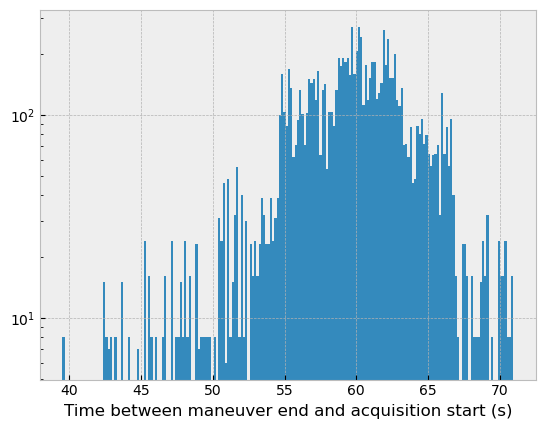

In [10]:
# Couple of outliers, otherwise almost all below 250 seconds gap between end of maneuver
# ('obs_start') and acquisition time ('tstart')
plt.hist(data_obss["dt_manvr_end_to_acq"], bins=200, log=True);
plt.xlabel("Time between maneuver end and acquisition start (s)");

In [11]:
# Filter down to good matches
ok = (np.abs(data_obss["dt_manvr_end_to_acq"]) < 250)
data = data_obss[ok]
data.info

<Table length=11016>
        name         dtype  shape    class    
------------------- ------- ----- ------------
             tstart float64             Column
              obsid   int64             Column
             obc_id    bool             Column
          halfwidth   int64             Column
            mag_aca float32             Column
            mag_obs float64             Column
              color float32             Column
           img_func  bytes7             Column
            ion_rad    bool             Column
            sat_pix    bool             Column
           agasc_id   int64             Column
              t_ccd float64             Column
               slot   int64             Column
           star_mag float32             Column
     search_success    bool             Column
      search_box_hw   int64             Column
           ccd_temp float64             Column
              ObsID   int64             Column
          mag_catid    bool            

### Get starcheck `obsids.json` to get proseco arguments for regenerating catalog

This allows using the current flight acquisition probability model and latest star mags.

In [12]:
import functools
import json
import parse_cm.paths

@functools.lru_cache(maxsize=128)
def get_obsids_info_json_for_load(load_name):
    """Read the obsids.json file for the given load name.

    Return a dict of obsid -> info dict, and do a little cleanup.
    """
    load_dir = parse_cm.paths.load_dir_from_load_name(load_name)
    with open(load_dir / "starcheck" / "obsids.json") as fh:
        obsids_info = json.load(fh)
    out = {info["obsid"]: info for info in obsids_info}
    for obs in out.values():
        del obs["commands"]
        if (acq_probs := obs.get("acq_probs")):
            for key in sorted(acq_probs):
                acq_probs[int(key)] = acq_probs[key]
                del acq_probs[key]
    return out

In [13]:
# Give an example of how to use the function
obsids_info = get_obsids_info_json_for_load("MAY1925A")
print("\n".join(sorted(obsids_info[29607].keys())))
print(obsids_info[29607]["acq_probs"])

DITHER_ON
DITHER_Y_AMP
DITHER_Y_FREQ
DITHER_Y_PHASE
DITHER_Z_AMP
DITHER_Z_FREQ
DITHER_Z_PHASE
GRATING
MON_DEC
MON_RA
SI
SIM_OFFSET_X
SIM_OFFSET_Z
SS_OBJECT
STARCHECK
TARGET_DEC
TARGET_NAME
TARGET_OFFSET_Y
TARGET_OFFSET_Z
TARGET_RA
acq
acq_probs
backstop
ccd_temp
ccd_temp_acq
ccd_temp_min
compass_file
config
date
dec
dither_acq
dither_guide
dot_file
dot_obsid
fid
fidsel
figure_of_merit
fyi
gui
guide_summ
mag_faint_red
mag_faint_yellow
mm_file
mon
n100_warm_frac
n_guide_summ
obs_tstart
obs_tstop
obsid
or_er_start
or_er_stop
or_file
orange_warn
plot_field_file
plot_file
proseco_args
ra
roll
thermal
tlr_file
warn
yellow_warn
{0: 0.978105001525794, 1: 0.775499171709299, 2: 0.754898230109662, 3: 0.968933070632644, 4: 0.950565165571223, 5: 0.942607145555309, 6: 0.916551420912807, 7: 0.9034145766095}


In [14]:
import gzip
import pickle
from proseco.catalog import ACATable

@functools.lru_cache(maxsize=128)
def get_aca_pickle_for_load(load_name) -> dict[float, ACATable]:
    """Read the aca pickle file for the given load name.

    Return a dict of obsid -> info dict, and do a little cleanup.
    """
    load_dir = parse_cm.paths.load_dir_from_load_name(load_name)
    with gzip.open(load_dir / "output" / f"{load_name}_proseco.pkl.gz", "rb") as fh:
        acas = pickle.load(fh)
    return acas

### Regenerate ACA catalog for `obsid` in `load_name`

This forces all the same stars but uses latest model and cal data.

In [15]:
import proseco

@functools.lru_cache(maxsize=32)
def get_aca_catalog(load_name, obsid):
    kwargs = get_obsids_info_json_for_load(load_name)[obsid]["proseco_args"].copy()
    for key in "acq_indexes", "guide_indexes":
        if key in kwargs:
            del kwargs[key]
    if (det := kwargs["detector"]) == "HRC-I":
        offset = 6
    elif det == "HRC-S":
        offset = 10
    else:
        offset = 0
    kwargs["include_ids_fid"] = [fid_id - offset for fid_id in kwargs["fid_ids"]]
    del kwargs["fid_ids"]
    if "focus_offset" not in kwargs:
        kwargs["focus_offset"] = 0.0
    aca = proseco.get_aca_catalog(**kwargs)
    return aca, kwargs

### Compute `p_acq_proseco` and `p_acq_model` for every flight acquisition

Loop over every acquisiton and regenerate the star catalog and pull out the
required values. This is a bit slow so we use caching where possible.

In [16]:
import tqdm

In [17]:
# Add columns for the proseco acq model and the proseco acq success probability
for name in "p_acq_proseco", "p_acq_model":
    if name not in data.colnames:
        data[name] = np.nan

In [18]:
for star_slot in tqdm.tqdm(data):
    if not np.isnan(star_slot["p_acq_model"]):
        pass
    try:
        acas = get_aca_pickle_for_load(star_slot["source"])
    except Exception as exc:
        print(f"Failed: {star_slot['source']} {star_slot['obsid']} {star_slot['agasc_id']}: {exc}")
        continue
    aca = acas[star_slot["obsid"]]
    star = aca.get_id(star_slot["agasc_id"])
    star_slot["p_acq_model"] = acq_success_prob(mag=star["mag"], t_ccd=aca.t_ccd_acq, halfwidth=star["halfw"])
    star_slot["p_acq_proseco"] = star["p_acq"]


100%|██████████| 11016/11016 [00:15<00:00, 722.29it/s] 


In [19]:
data.write("acq_stats_with_probs.fits", overwrite=True)

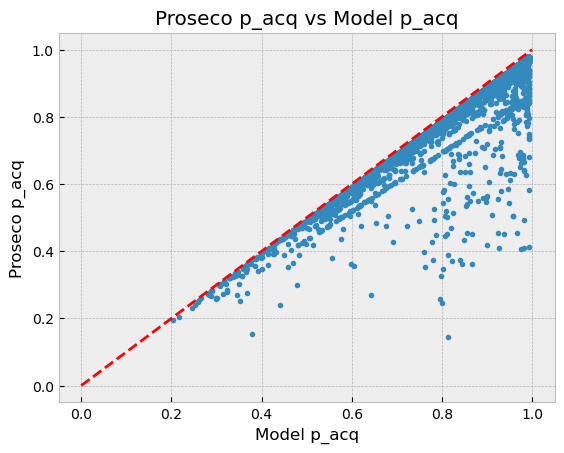

In [20]:
plt.plot(data["p_acq_model"], data["p_acq_proseco"],  ".")
plt.plot([0, 1], [0, 1], "r--")
plt.title("Proseco p_acq vs Model p_acq")
plt.ylabel("Proseco p_acq")
plt.xlabel("Model p_acq");

In [21]:
# spoiler: 44572 MAY0123A

In [22]:
ok = (data["p_acq_model"] - data["p_acq_proseco"] < 0.2)
data.pprint_include_names = ["obsid", "source", "agasc_id", "mag_aca", "p_acq_model", "p_acq_proseco", "fail"]
44572 in data[ok]["obsid"]

False

In [23]:
def plot_fails_mag_aca_vs_t_ccd(data, year0=2015.0):
    ok = (data["year"] > year0) & ~data["fail"].astype(bool)
    da = data[ok]
    fuzzx = np.random.uniform(-0.3, 0.3, len(da))
    fuzzy = np.random.uniform(-0.125, 0.125, len(da))
    plt.plot(da["t_ccd"] + fuzzx, da["mag_aca"] + fuzzy, ".C0", markersize=4)

    ok = (data["year"] > year0) & data["fail"].astype(bool)
    da = data[ok]
    fuzzx = np.random.uniform(-0.3, 0.3, len(da))
    fuzzy = np.random.uniform(-0.125, 0.125, len(da))
    plt.plot(da["t_ccd"] + fuzzx, da["mag_aca"] + fuzzy, ".C1", markersize=4, alpha=0.8)

    # plt.xlim(-18, -10)
    # plt.ylim(7.0, 11.1)
    x0, x1 = -16, 3
    plt.xlim(x0, x1)
    plt.xlabel("T_ccd (C)")
    plt.ylabel("Mag_aca")
    plt.title(f"Acq successes (blue) and failures (orange) since {year0}")
    plt.grid(True)

In [24]:
def plot_acqs_mag_aca_vs_t_ccd(data):
    plt.figure(figsize=(8, 8))
    for subplot, halfwidth in enumerate([60, 80, 100, 120, 140, 160]):
        plt.subplot(3, 2, subplot + 1)
        ok = (data["halfwidth"] > halfwidth - 10) & (
            data["halfwidth"] <= halfwidth + 10
        )
        plot_fails_mag_aca_vs_t_ccd(data[ok], year0=2023.5)
        plt.title(f"Acq success (blue) fail (red)\nbox={halfwidth}")
        plt.xlim(-15, 0)
        plt.ylim(5.0, 12.0)
    plt.tight_layout()

### Plot acq `mag_aca` vs `t_ccd` distribution per search box size

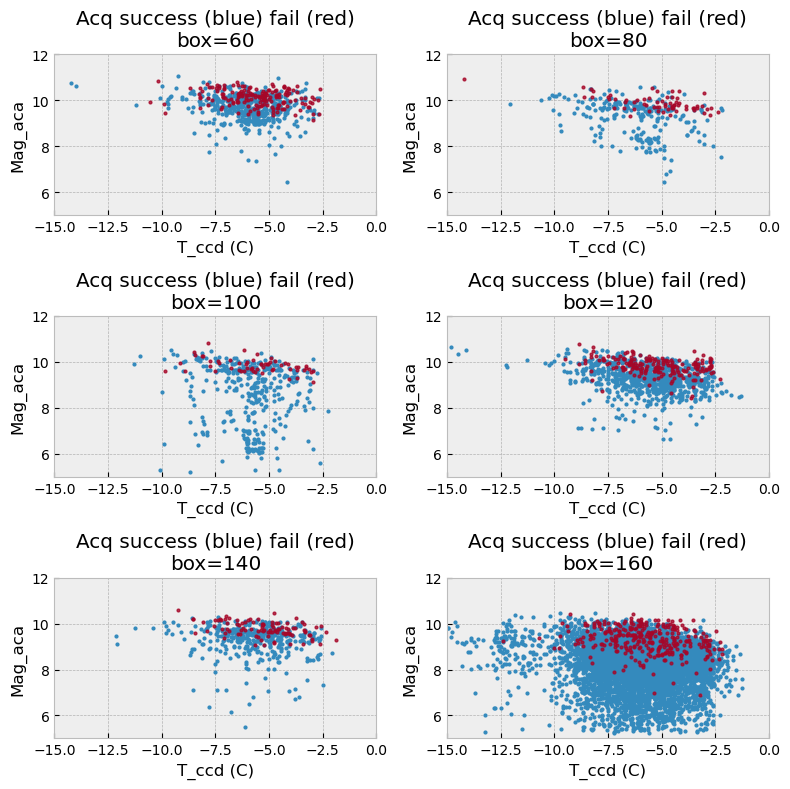

In [25]:
plot_acqs_mag_aca_vs_t_ccd(data)

### Distribution of recent data at warm CCD temperatures

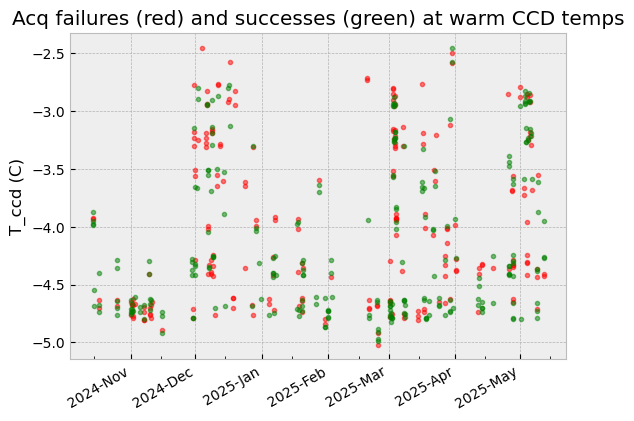

In [26]:
dok = data[(data["ccd_temp"] > -5.0) & (data['mag_aca'] > 9.5) & (data["ccd_temp"] < -2.0)]
fail = dok["fail"].astype(bool)
t_ccd = dok["ccd_temp"] + np.random.uniform(-0.1, 0.1, len(dok))
_ = plot_cxctime(dok["tstart"][fail], t_ccd[fail], ".", color="r", alpha=0.5)
_ = plot_cxctime(dok["tstart"][~fail], t_ccd[~fail], ".", color="g", alpha=0.5)
plt.title("Acq failures (red) and successes (green) at warm CCD temps")
plt.ylabel("T_ccd (C)");

## Data analysis

### Code for making final plots of binned flight acq data and models

In [27]:
@dataclass
class ProbFail:
    p_fail: float
    p_fail_lower: float
    p_fail_upper: float
    mean_t_ccd: float
    mean_mag: float
    n_fail: int
    n_acq: int
    t_ccd_err_lo: float
    t_ccd_err_hi: float
    p_fail_model: float
    p_fail_proseco: float

In [28]:
def calc_binned_pfail(data, mag0, mag1, t_ccd0, t_ccd1, halfwidth=None):
    fail = data["fail"].astype(bool)
    ok = (
        (data["mag_aca"] >= mag0)
        & (data["mag_aca"] < mag1)
        & (data["t_ccd"] >= t_ccd0)
        & (data["t_ccd"] < t_ccd1)
    )
    if halfwidth is not None:
        ok &= data["halfwidth"] == halfwidth

    n_fail = np.count_nonzero(fail[ok])
    n_acq = np.count_nonzero(ok)
    if n_acq < 15:
        return None

    p_fail_proseco = 1 - np.mean(data["p_acq_proseco"][ok])
    p_fail_model = 1 - np.mean(data["p_acq_model"][ok])

    p_fail = n_fail / n_acq
    _, p_fail_lower, p_fail_upper = binomial_confidence_interval(n_fail, n_acq)
    # Ensure that error bars are >= 0. We will want to plot p_fail as n_fail/n_acq,
    # instead of (e.g.) p_fail = 50th percentile.
    p_fail_lower = min(p_fail, p_fail_lower)
    p_fail_upper = max(p_fail, p_fail_upper)
    mean_t_ccd = np.mean(data["t_ccd"][ok])
    mean_mag = np.mean(data["mag_aca"][ok])
    out = ProbFail(
        p_fail,
        p_fail_lower,
        p_fail_upper,
        mean_t_ccd,
        mean_mag,
        n_fail,
        n_acq,
        t_ccd_err_hi=t_ccd1 - mean_t_ccd,
        t_ccd_err_lo=mean_t_ccd - t_ccd0,
        p_fail_model=p_fail_model,
        p_fail_proseco=p_fail_proseco,
    )
    return out

In [29]:
# MAG_VALS = [8.0, 9.0, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75]
# MAG_BINS = [7.5, 8.5, 9.25, 9.625, 9.875, 10.125, 10.375, 10.625, 11.25]
# These match the ACA mag bins used in the model grid
MAG_VALS = [9.0, 9.5, 10.0, 10.5]
MAG_BINS = [8.75, 9.25, 9.75, 10.25, 10.75]

In [30]:
# These match the T_ccd bins used in the model grid
T_CCD_VALS = np.array([-15, -13, -11, -9, -8, -7, -6, -5, -4, -3, -2, 0, 2])
T_CCD_BINS = [
    -15.5,
    -14.0,
    -12.0,
    -10.0,
    -8.5,
    -7.5,
    -6.5,
    -5.5,
    -4.5,
    -3.5,
    -2.5,
    -1.0,
    1.0,
    2.5,
]

In [31]:
calc_binned_pfail(data, mag0=9.75, mag1=10.25, t_ccd0=-7.5, t_ccd1=-6.5, halfwidth=120)

ProbFail(p_fail=0.3469387755102041, p_fail_lower=0.28266475154250986, p_fail_upper=0.4173847820001908, mean_t_ccd=-6.904650814679204, mean_mag=9.970435, n_fail=17, n_acq=49, t_ccd_err_lo=0.5953491853207957, t_ccd_err_hi=0.4046508146792043, p_fail_model=0.2984404719917909, p_fail_proseco=0.3166025097010774)

In [32]:
def get_binned_pfails(
    data, halfwidth=None, year_min=None, print_vals=True
) -> list[list[ProbFail]]:
    pfs_list = []
    if year_min is not None:
        data = data[data["year"] > year_min]
    for mag, mag0, mag1 in zip(MAG_VALS, MAG_BINS[:-1], MAG_BINS[1:]):
        pfs = []
        for t_ccd, t_ccd0, t_ccd1 in zip(T_CCD_VALS, T_CCD_BINS[:-1], T_CCD_BINS[1:]):
            pf = calc_binned_pfail(
                data, mag0, mag1, t_ccd0, t_ccd1, halfwidth=halfwidth
            )
            if pf is not None:
                pfs.append(pf)
                if print_vals:
                    print(
                        f"mag={mag} mean_mag_aca={pf.mean_mag:.2f} "
                        f"t_ccd={t_ccd} t_ccd_mean={pf.mean_t_ccd:.2f} "
                        f"p_fail={pf.n_fail}/{pf.n_acq}={pf.p_fail:.2f}"
                    )
        pfs_list.append(pfs)
    return pfs_list

In [33]:
def _plot_flight_model_and_data(color, pfs_list: list[list[ProbFail]], halfwidth=160):
    # This computes probabilities for 160 arcsec boxes, corresponding to raw data
    t_ccds = np.linspace(-14, -2, 20)

    # pf1, pf2 have p_fail, p_fail_lower, p_fail_upper, mean_t_ccd, mean_mag_aca, n_fail, n_acq
    for ii, pfs in enumerate(pfs_list):
        clr = f"C{ii}"
        for pf in pfs:
            yerr = np.array(
                [pf.p_fail - pf.p_fail_lower, pf.p_fail_upper - pf.p_fail]
            ).reshape(2, 1)
            plt.errorbar(
                pf.mean_t_ccd,
                pf.p_fail,
                xerr=np.array([pf.t_ccd_err_lo, pf.t_ccd_err_hi]).reshape(2, 1),
                yerr=yerr,
                color=clr,
                marker="o",
                alpha=0.6,
            )

        # Plot the model values
        x = [pf.mean_t_ccd for pf in pfs]
        y = [pf.p_fail_proseco for pf in pfs]
        plt.plot(x, y, color=clr, linestyle="-", label=f"{MAG_VALS[ii]} mag (solid=proseco, dashed=model)")
        y = [pf.p_fail_model for pf in pfs]
        plt.plot(x, y, color=clr, linestyle="--")

    # plt.xlim(-16, None)
    plt.legend()
    plt.ylim(0, 1)
    plt.xlim(-14, 2)
    plt.xlabel("T_ccd")
    plt.ylabel("P_fail")
    plt.title(f"P_fail flight model and data (halfw={halfwidth})")
    plt.grid(True)

In [34]:
def plot_flight_model_and_data(flt, halfwidth=160, print_vals=True, year_min=None):
    pfails_list = get_binned_pfails(
        flt, halfwidth=halfwidth, year_min=year_min, print_vals=print_vals
    )
    _plot_flight_model_and_data(color=1.0, pfs_list=pfails_list, halfwidth=halfwidth)
    plt.title(f"P_fail model and data (halfw={halfwidth})")

### Compare to flight data

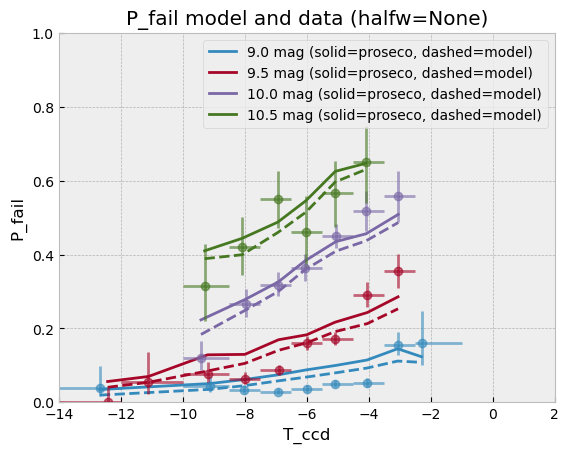

In [35]:
# In this plot there is no filtering on halfwidth. The model prediction is
# the mean of the model prediction for each data point in the bin.
plot_flight_model_and_data(data, halfwidth=None, print_vals=False)